In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
from matplotlib import pyplot
import matplotlib.dates as mdates

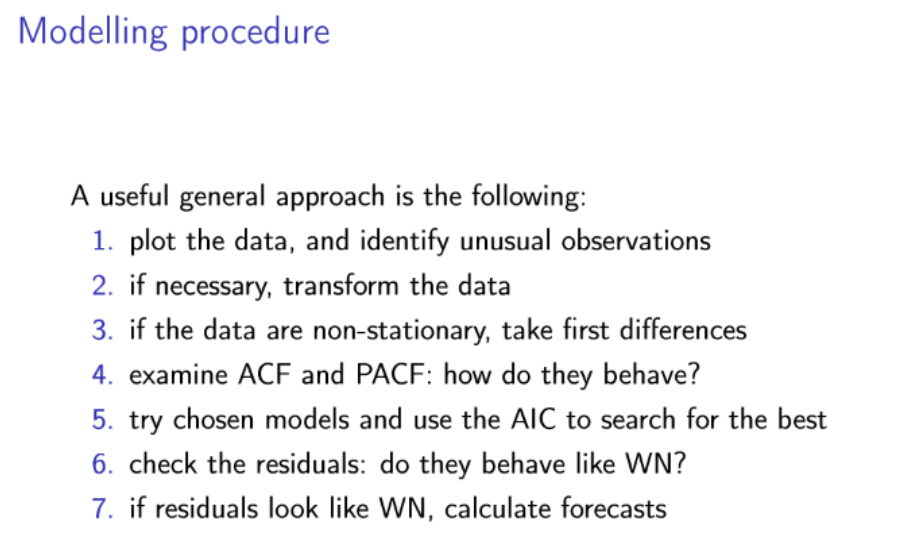

## Read and plot the time series

In [2]:
file_path = 'Data/exchange.csv'
df_exchange = pd.read_csv(file_path)
df_exchange.head(5)

,date,data,currency
0,2014-09-17,1.295908,EURUSD=X
1,2014-09-18,1.285000,EURUSD=X
2,2014-09-19,1.292006,EURUSD=X
3,2014-09-22,1.284142,EURUSD=X
4,2014-09-23,1.285149,EURUSD=X


In [3]:
#filter to bitcoin-usd
df_bitcoin = df_exchange[df_exchange['currency'] == 'BTC-USD']
df_bitcoin = df_bitcoin.reset_index(drop=True)
df_bitcoin['date'] = pd.to_datetime(df_bitcoin['date'])
df_bitcoin.head()

,date,data,currency
0,2014-09-17,457.334015,BTC-USD
1,2014-09-18,424.440002,BTC-USD
2,2014-09-19,394.795990,BTC-USD
3,2014-09-20,408.903992,BTC-USD
4,2014-09-21,398.821014,BTC-USD


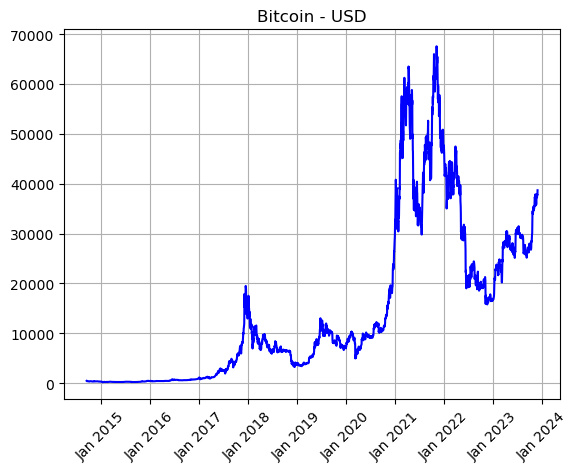

In [4]:
# Plotting the data as a time series index
plt.plot(df_bitcoin['date'], df_bitcoin['data'],color='blue', linestyle='-')

plt.title('Bitcoin - USD')
plt.grid(True)

# Set the date format for x-axis ticks
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

# Specify the frequency of ticks for months
plt.gca().xaxis.set_major_locator(mdates.YearLocator())

# Rotate the x-axis labels for better readability (optional)
plt.xticks(rotation=45)

plt.show()

In [5]:
#check for missing values
df_bitcoin.isnull().sum()

date        0
data        0
currency    0
dtype: int64

## Check the autocorrelations

In [6]:
acorr = sm.tsa.acf(df_bitcoin['data'], nlags = 730)
#Most important lags 1 (day), 30 (month), 90 (quarter), 365 (year)
print(acorr[0],acorr[1],acorr[30],acorr[90],acorr[365])

1.0 0.9983658900025849 0.9490380104753976 0.83191264503259 0.4392909513750293


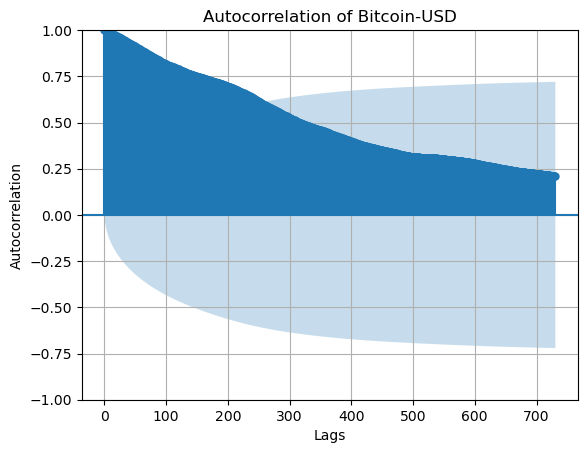

In [7]:
#Autocorrelation (730 lags = 2 years)
plot_acf(x = df_bitcoin['data'], lags=730, alpha=0.05)
plt.title('Autocorrelation of Bitcoin-USD')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.grid(True)
plt.show()

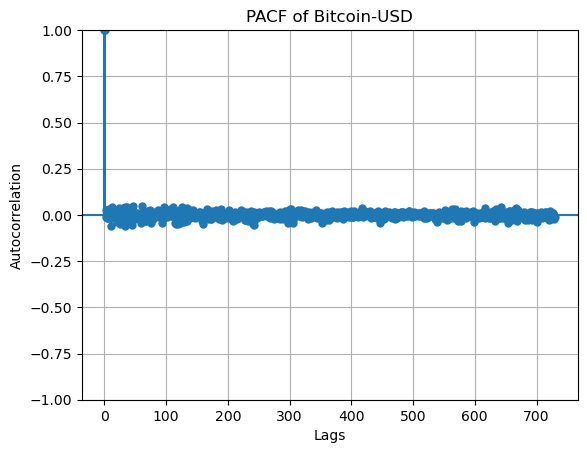

In [8]:
#partial auto correlation 
plot_pacf(x = df_bitcoin['data'], lags=730, alpha=0.05,method='ywm')  # Adjust 'lags' as needed
plt.title('PACF of Bitcoin-USD')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.grid(True)
plt.show()

## First difference (as time series is not stationary)

In [9]:
df_bitcoin_diff = df_bitcoin.copy()
#create column for first difference
df_bitcoin_diff['diff'] = pd.Series.diff(df_bitcoin['data'])
df_bitcoin_diff.fillna(0, inplace=True)


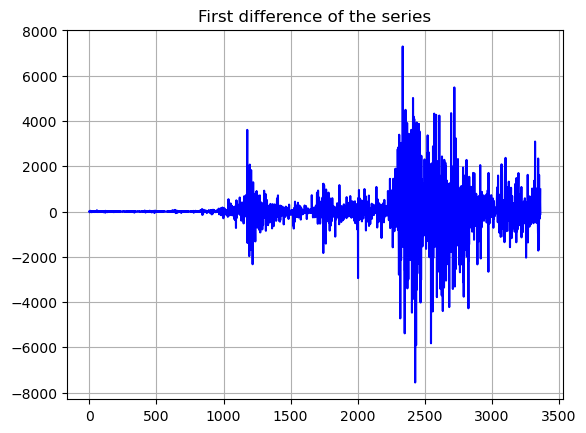

In [10]:
# Plotting differentiated series
plt.plot(df_bitcoin_diff['diff'], color='blue', linestyle='-')

plt.title('First difference of the series')
plt.grid(True)
plt.show()

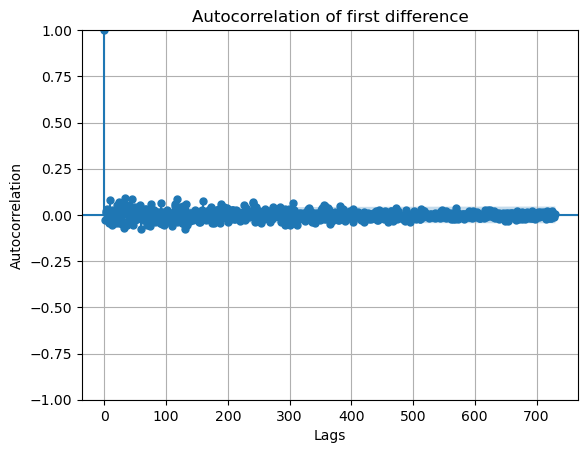

In [11]:
#Autocorrelation of first difference
plot_acf(x = df_bitcoin_diff['diff'], lags=730, alpha=0.05)  # Adjust 'lags' as needed
plt.title('Autocorrelation of first difference')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.grid(True)
plt.show()

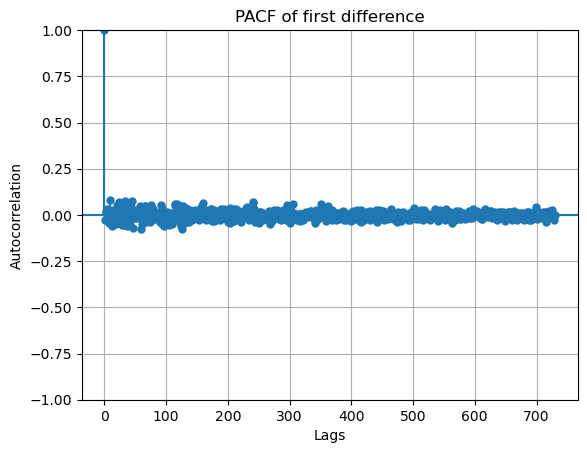

In [12]:
#pacf of the first difference
plot_pacf(x = df_bitcoin_diff['diff'], lags=730, alpha=0.05, method = 'ywm')  # Adjust 'lags' as needed
plt.title('PACF of first difference')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.grid(True)
plt.show()

## Fit an ARIMA model

In [13]:
train_length = int(len(df_bitcoin) * 0.85)  # 85% for training
# Split into train and test sets last 15% for test of forecasting
train_data = df_bitcoin.iloc[:train_length]
test_data = df_bitcoin.iloc[train_length:]
test_data.head()

,date,data,currency
2858,2022-07-15,20836.328125,BTC-USD
2859,2022-07-16,21190.316406,BTC-USD
2860,2022-07-17,20779.343750,BTC-USD
2861,2022-07-18,22485.689453,BTC-USD
2862,2022-07-19,23389.433594,BTC-USD


In [14]:
#ARIMA p, d, q model
data = train_data['data'].values
model = ARIMA(data, order=(0, 1, 1))
a1 = model.fit()

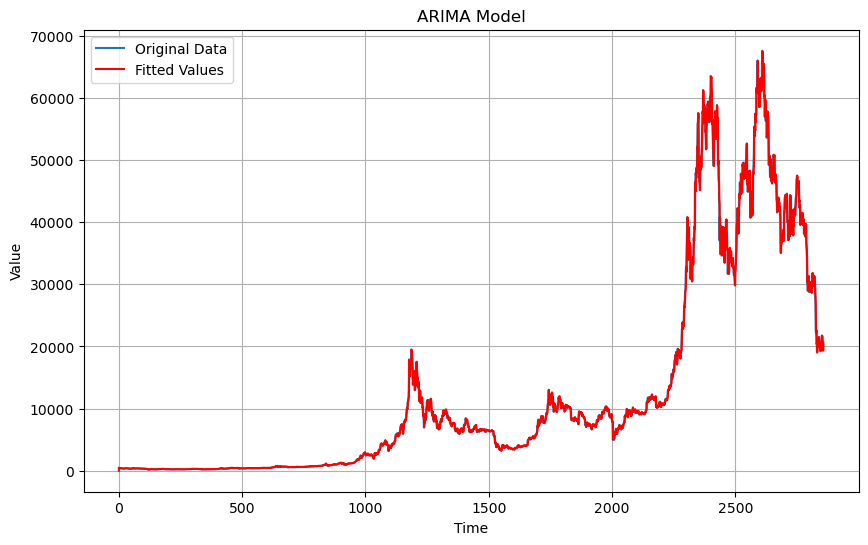

In [15]:
# Fitted values
fit1 = a1.fittedvalues

# Plot original data and fitted values
plt.figure(figsize=(10, 6))
plt.plot(data, label='Original Data')
plt.plot(fit1, color='red', label='Fitted Values')
plt.title('ARIMA Model')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

## Calculate AIC 

In [16]:
#AIC of the model
aic = a1.aic
aic

46349.00561622301

## Check the residuals

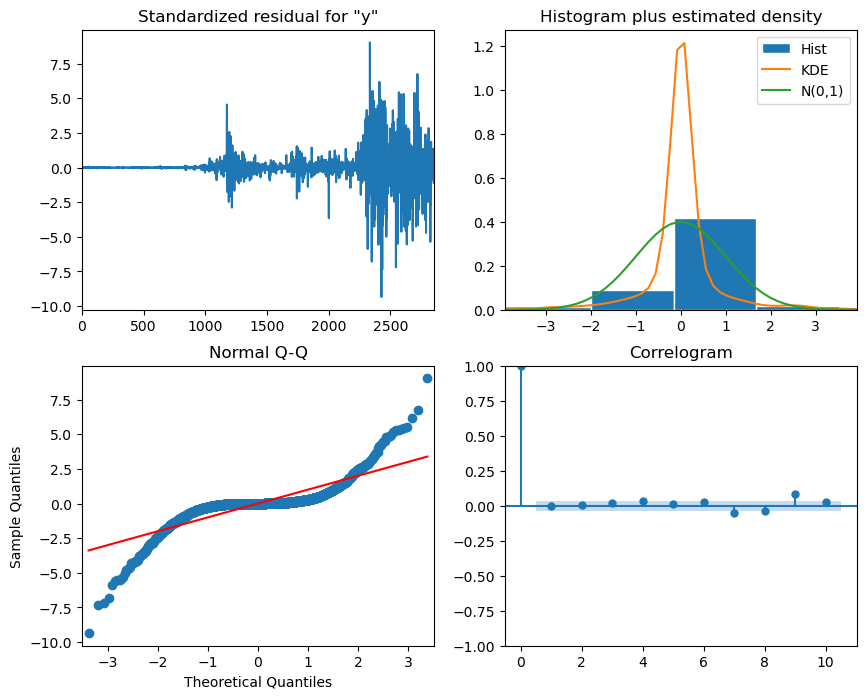

In [17]:
#Check the residuals
a1.plot_diagnostics(figsize=(10, 8))
plt.show()

## Forecast with the model

In [18]:
#static forecast
# Forecast the next 100 steps
forecast_steps = 100
forecast = a1.forecast(steps=forecast_steps)
forecast

array([20559.95046506, 20559.95046506, 20559.95046506, 20559.95046506,
       20559.95046506, 20559.95046506, 20559.95046506, 20559.95046506,
       20559.95046506, 20559.95046506, 20559.95046506, 20559.95046506,
       20559.95046506, 20559.95046506, 20559.95046506, 20559.95046506,
       20559.95046506, 20559.95046506, 20559.95046506, 20559.95046506,
       20559.95046506, 20559.95046506, 20559.95046506, 20559.95046506,
       20559.95046506, 20559.95046506, 20559.95046506, 20559.95046506,
       20559.95046506, 20559.95046506, 20559.95046506, 20559.95046506,
       20559.95046506, 20559.95046506, 20559.95046506, 20559.95046506,
       20559.95046506, 20559.95046506, 20559.95046506, 20559.95046506,
       20559.95046506, 20559.95046506, 20559.95046506, 20559.95046506,
       20559.95046506, 20559.95046506, 20559.95046506, 20559.95046506,
       20559.95046506, 20559.95046506, 20559.95046506, 20559.95046506,
       20559.95046506, 20559.95046506, 20559.95046506, 20559.95046506,
      

Test RMSE: 605.316


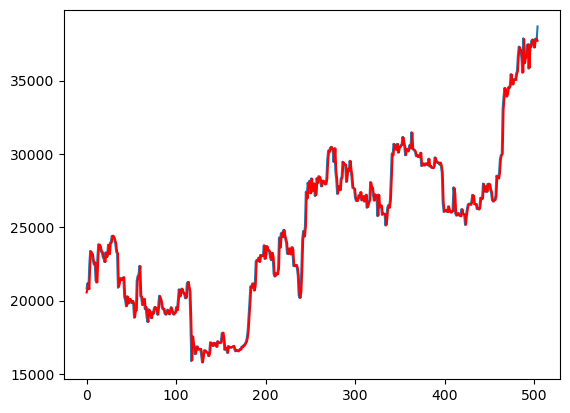

In [19]:
#rolling forecast (always just forecast the next value)
predictions = list()
data = data.tolist()
test = test_data['data'].values

# walk-forward validation
for t in range(len(test)):
    model = ARIMA(data, order=(0, 1, 1))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    data.append(obs)
    #print('predicted=%f, expected=%f' % (yhat, obs))

    # evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

# plot forecasts against actual outcomes
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()